<a href="https://colab.research.google.com/github/SiriNadig/shanghaitech-crowd-density/blob/main/Density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("tthien/shanghaitech-with-people-density-map")
print("Path to dataset files:", path)


100%|██████████| 4.79G/4.79G [00:47<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tthien/shanghaitech-with-people-density-map/versions/1


In [2]:
!pip install kagglehub h5py matplotlib torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import kagglehub

path = kagglehub.dataset_download("tthien/shanghaitech-with-people-density-map")
img_dir = f"{path}/ShanghaiTech/part_A/train_data/images"
gt_dir = f"{path}/ShanghaiTech/part_A/train_data/ground-truth-h5"


In [4]:
import os
img_dir = os.path.join(path, "ShanghaiTech/part_A/train_data/images")
gt_dir = os.path.join(path, "ShanghaiTech/part_A/train_data/ground-truth-h5")

In [4]:
import torch
from torch.utils.data import Dataset, Subset
import h5py, os
from PIL import Image
import numpy as np
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir):
        self.img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.gt_dir = gt_dir
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        gt_path = os.path.join(self.gt_dir, os.path.basename(img_path).replace(".jpg", ".h5"))
        with h5py.File(gt_path, 'r') as hf:
            density = np.array(hf['density'])
            density = torch.tensor(density, dtype=torch.float32).unsqueeze(0)
            density = torch.nn.functional.interpolate(density.unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False).squeeze(0)

        return img, density


In [5]:
import torch.nn as nn
import torchvision.models as models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])  # Up to conv4_3

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(128, 64, 1), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x


In [6]:
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CrowdDataset(img_dir, gt_dir)
subset = Subset(dataset, range(0, 100))  # Use only 100 images
loader = DataLoader(subset, batch_size=4, shuffle=True)

model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:04<00:00, 117MB/s]


In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CrowdDataset(img_dir, gt_dir)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(2):
    model.train()
    total_loss = 0.0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        outputs = model(imgs)
        outputs = torch.nn.functional.interpolate(outputs, size=targets.shape[-2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")


Epoch 1: Loss = 0.0000
Epoch 2: Loss = 0.0000


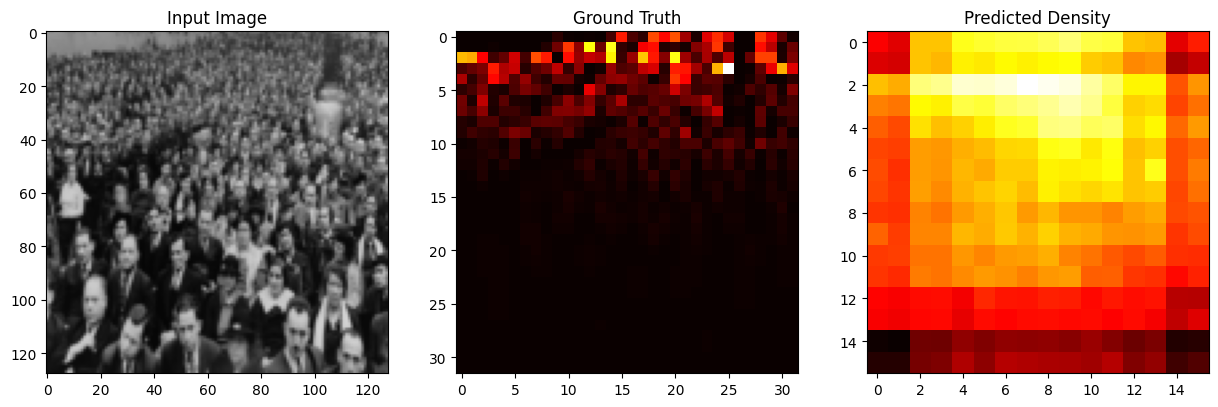

In [8]:
import matplotlib.pyplot as plt

def show_prediction():
    model.eval()
    img, target = dataset[0]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(target.squeeze().numpy(), cmap='hot')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(pred.numpy(), cmap='hot')
    plt.title("Predicted Density")

    plt.show()

show_prediction()
